In [1]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-mkg1ti1w
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-mkg1ti1w
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-zott73wx/residual-flows_070a2807f23e4766b67d4205679f99b0
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-zott73wx/residual-flows_070a2807f23e4766b67d4205679f99b0
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=59c504ec9e745588079f158ed051d155f385b3d4c0e713516dfd658dbc4bfc1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-_qbob9uo/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=c55305

In [2]:
# Import basic libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import Normflow
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# For saving and loading
import pickle
%matplotlib inline

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

# Normalizing Flow demo

In [ ]:
K = 10
beta = 1.0
#torch.manual_seed(0)

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

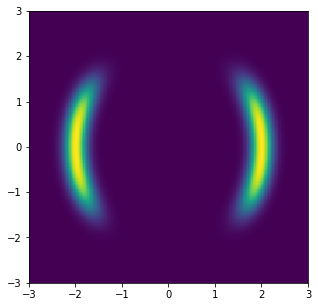

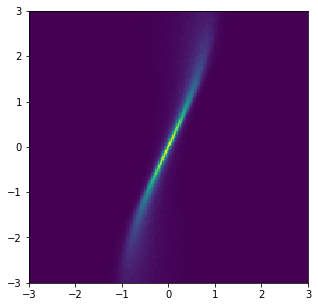

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(2), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z)
        #print(log_q)
        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=nf.distributions.DiagGaussian(2), flows=flows, p=target).to(device)

 40%|███▉      | 1981/5000 [00:07<00:11, 266.66it/s]

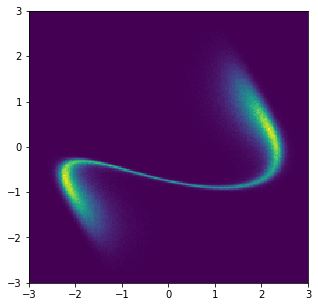

 80%|███████▉  | 3985/5000 [00:15<00:03, 260.74it/s]

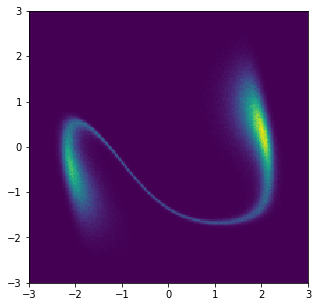

100%|██████████| 5000/5000 [00:19<00:00, 251.18it/s]


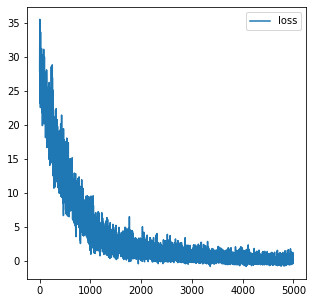

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

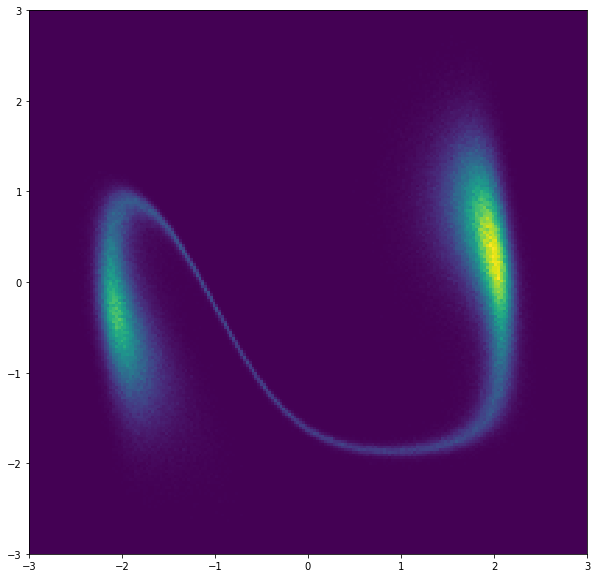

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Utility functions regarding Cryo-EM

In [ ]:
# Install Openmm (takes approx 5 minutes to run)
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
--2022-06-03 21:01:00--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   331MB/s    in 0.3s    

2022-06-03 21:01:01 (331 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4

In [ ]:
from openmm import *
from openmm.app import *
from openmm.unit import *

In [15]:
# Frequently used definitions
dtype = torch.FloatTensor

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'water_img1024_dim25_nse1_blob0.001_q0.2.pkl' #'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 5
beta = 10.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


In [4]:
# Utility functions for putting gaussian blobs and Cryo-EM image plotting

def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_mat=torch.eye(3)):
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))

    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    normals = torch.zeros_like(x, device=device)

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    new_coords = coords @ rot_mat.T

    for row in new_coords.double():
        normals += torch.exp(-(torch.norm(pos - row[0:2], dim=2)**2)/(2*(blob_var)))/(2*np.pi*blob_var)

    return normals/len(new_coords) + noise_matrix


def plot_cryoem_imgs(img_list, skip_by=1, Q=Q):
    for idx, img in enumerate(img_list):
        if idx % skip_by == 0:
            c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
            plt.colorbar(c)

            plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
            plt.show()

print(device)

cpu


In [5]:
class pot_energy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        reshaped_input = input.reshape(num_atoms, 3)
        ctx.save_for_backward(reshaped_input)

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return torch.tensor(state.getPotentialEnergy()._value).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        reshaped_input, = ctx.saved_tensors

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return -grad_output * torch.tensor(state.getForces(asNumpy=True)._value).reshape(-1, num_atoms*3).to(device)


def potential(vec):
    eq_length, k_length = 0.101181082494, 462750.4
    eq_angle, k_angle = 1.88754640288, 836.8
    #print(vec)

    bond1 = vec[0:3] - vec[3:6]
    bond2 = vec[0:3] - vec[6:9]

    bond_pot = k_length*((eq_length - torch.norm(bond1))**2 + (eq_length - torch.norm(bond2))**2)
    angle_pot = k_angle*(eq_angle - torch.acos(torch.dot(bond1, bond2)/(torch.norm(bond1)*torch.norm(bond2))))**2

    return angle_pot + bond_pot

atm_crd = np.array([[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]])
print(potential(torch.tensor(atm_crd.flatten())))

tensor(0.0288, dtype=torch.float64)


# Water Molecule Images

In [ ]:
topology = Topology()
chain = topology.addChain()
residue = topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = topology.addAtom("O", element_O, residue)
atom1 = topology.addAtom("H", element_H, residue)
atom2 = topology.addAtom("H", element_H, residue)
topology.addBond(atom0, atom1)
topology.addBond(atom0, atom2)

#pdb = PDBFile(pdbfile)
forcefield = ForceField(forcefile)
system = forcefield.createSystem(topology, nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(T*kelvin, 1/picosecond, 1*femtoseconds)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.1],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))
#simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
#        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    print(state0.getPositions(asNumpy=True))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

Potential energy
0.0022257892414927483 kJ/mol
Atomic positions
[[ 0.00271355  0.00459892  0.0099479 ]
 [ 0.04101541  0.09167872 -0.02451493]
 [-0.0879112   0.02370605  0.05068715]] nm
Volume
8.0 nm**3
Forces
[[ 13.64702129 -27.6960144   -1.63703251]
 [-15.60775948   9.21677685   5.94231319]
 [  1.9607383   18.47923851  -4.30528069]] kJ/(nm mol)


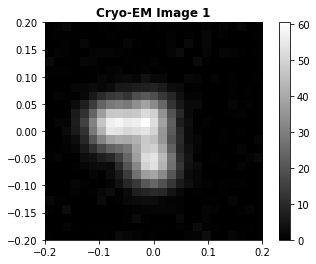

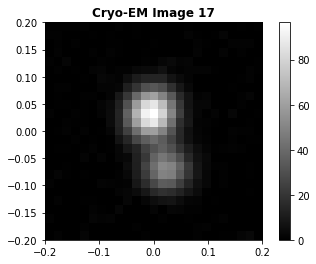

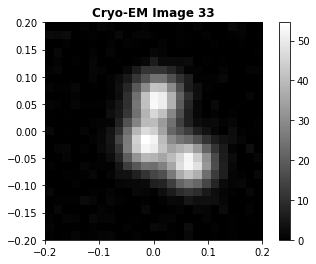

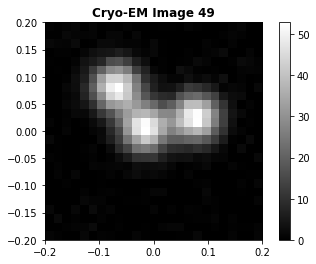

In [6]:
with open(pklfile, 'rb') as inp:
    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    img_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]

plot_cryoem_imgs(img_list, skip_by=16)

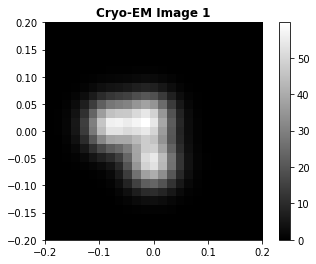

tensor(601.6715)
tensor([[-0.0103,  0.0218,  0.0047],
        [-0.0828,  0.0113, -0.0651],
        [-0.0038, -0.0601,  0.0637]])


In [7]:
idx = 0
img = torch_createblobs(pos_list[idx], rot_mat=rot_mats[idx])

plot_cryoem_imgs([img], skip_by=1)
print(torch.norm(img - img_list[idx])**2)
print(pos_list[idx] @ rot_mats[idx].T)

# Normalizing Flows: Gaussian Base Distribution

In [20]:
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

In [21]:
class nfmodel(nn.Module):
    def __init__(self, flows=flows):
        super().__init__()

        self.q0 = nf.distributions.DiagGaussian(num_atoms*3)
        self.flows = nn.ModuleList(flows)

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        #print(z)
        
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, target=img_list[idx], rot_mat=rot_mats[idx], beta=beta):
        z, log_q = self.q0(num_samples)
        #log_q = 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            log_imerr -= torch.norm(target - torch_createblobs(molecule.reshape(3,3)/100, rot_mat = rot_mat))**2
            log_pot -= potential(molecule.flatten()/100)   #pot_energy.apply/kBxAvoxT

        return torch.mean(log_q) - (log_imerr/(2*noise_var) + beta*log_pot/kBxAvoxT)/num_samples 


model = nfmodel(flows=flows).to(device)

  0%|          | 1/500 [00:00<02:05,  3.96it/s]

89476.36


 10%|█         | 51/500 [00:12<01:44,  4.28it/s]

25977.693


 20%|██        | 101/500 [00:24<01:33,  4.29it/s]

10907.788


 30%|███       | 151/500 [00:36<01:20,  4.31it/s]

5728.081


 40%|████      | 201/500 [00:48<01:16,  3.93it/s]

4020.407


 50%|█████     | 251/500 [00:59<00:58,  4.29it/s]

2815.4685


 60%|██████    | 301/500 [01:11<00:47,  4.17it/s]

2373.1929


 70%|███████   | 351/500 [01:23<00:34,  4.28it/s]

2035.6055


 80%|████████  | 401/500 [01:35<00:22,  4.32it/s]

1861.3444


 90%|█████████ | 451/500 [01:47<00:11,  4.27it/s]

1778.4008


100%|██████████| 500/500 [01:59<00:00,  4.20it/s]


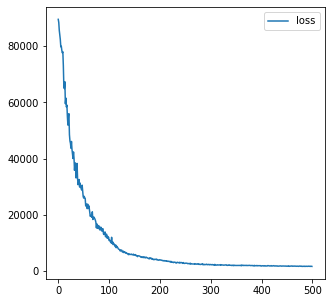

In [22]:
# Train model
max_iter = 00
num_samples = 100
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

tensor(0.0984, grad_fn=<CopyBackwards>)
tensor(0.1127, grad_fn=<CopyBackwards>)
tensor(0.1460, grad_fn=<CopyBackwards>)
tensor(36.9766)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


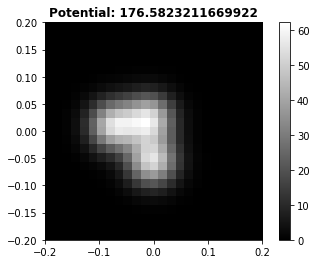

tensor(0.1098, grad_fn=<CopyBackwards>)
tensor(0.1176, grad_fn=<CopyBackwards>)
tensor(0.1551, grad_fn=<CopyBackwards>)
tensor(32.8388)


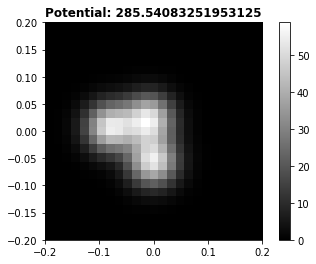

tensor(0.1036, grad_fn=<CopyBackwards>)
tensor(0.1132, grad_fn=<CopyBackwards>)
tensor(0.1513, grad_fn=<CopyBackwards>)
tensor(34.1664)


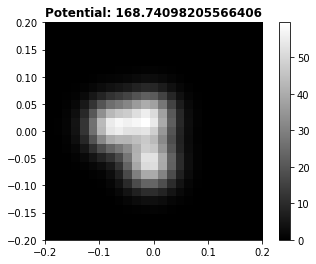

tensor(0.1062, grad_fn=<CopyBackwards>)
tensor(0.1080, grad_fn=<CopyBackwards>)
tensor(0.1442, grad_fn=<CopyBackwards>)
tensor(51.9675)


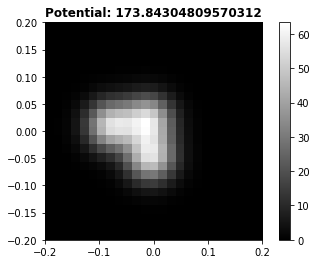

tensor(0.1039, grad_fn=<CopyBackwards>)
tensor(0.1030, grad_fn=<CopyBackwards>)
tensor(0.1482, grad_fn=<CopyBackwards>)
tensor(59.3384)


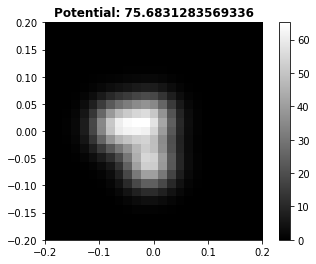

tensor(0.0950, grad_fn=<CopyBackwards>)
tensor(0.1068, grad_fn=<CopyBackwards>)
tensor(0.1429, grad_fn=<CopyBackwards>)
tensor(53.7681)


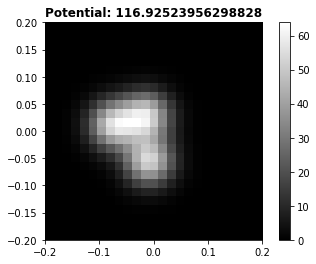

tensor(0.0973, grad_fn=<CopyBackwards>)
tensor(0.1048, grad_fn=<CopyBackwards>)
tensor(0.1453, grad_fn=<CopyBackwards>)
tensor(61.0141)


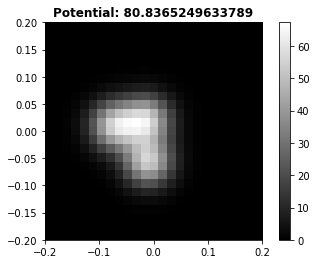

tensor(0.0999, grad_fn=<CopyBackwards>)
tensor(0.1123, grad_fn=<CopyBackwards>)
tensor(0.1524, grad_fn=<CopyBackwards>)
tensor(44.5433)


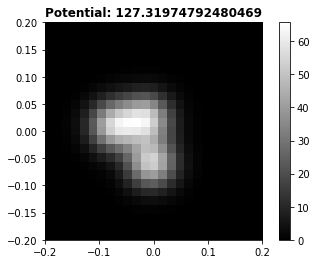

tensor(0.1166, grad_fn=<CopyBackwards>)
tensor(0.1081, grad_fn=<CopyBackwards>)
tensor(0.1552, grad_fn=<CopyBackwards>)
tensor(37.8699)


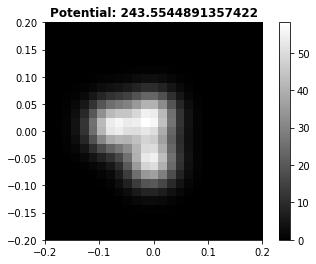

tensor(0.1145, grad_fn=<CopyBackwards>)
tensor(0.1070, grad_fn=<CopyBackwards>)
tensor(0.1550, grad_fn=<CopyBackwards>)
tensor(39.5153)


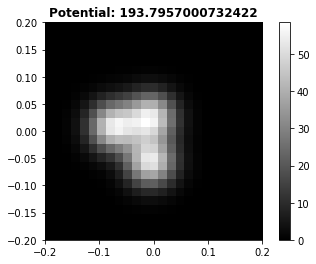

In [23]:
molecules, _ = model.sample(num_samples=10)

for molecule in molecules:
    atm_crd = molecule.reshape(3,3)/100
    print(torch.norm(atm_crd[0] - atm_crd[1]))
    print(torch.norm(atm_crd[0] - atm_crd[2]))
    print(torch.norm(atm_crd[1] - atm_crd[2]))

    img = torch_createblobs(molecule.reshape(3,3)/100, rot_mat=rot_mats[idx]).data
    c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[idx]))
    plt.title(f'Potential: {potential(molecule.flatten()/100)}', fontweight = "bold")
    plt.show()

# Normalizing Flows: MD Simulated Base Distribution

In [ ]:
import random

#lst = torch.vstack([i.reshape(-1, num_atoms*3) for i in pos_list[idx:]])
#print(lst.shape)

flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

In [ ]:
class nfmodel_md(nn.Module):
    def __init__(self, flows=flows):
        super().__init__()

        self.q0 = [i.reshape(-1, num_atoms*3) for i in pos_list[idx:]]
        self.flows = nn.ModuleList(flows)

    def sample(self, num_samples=1):
        z, log_q = torch.vstack(random.sample(self.q0, num_samples)), 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, target=img_list[idx], rot_mat=rot_mats[idx], beta=beta):
        z, log_q = torch.vstack(random.sample(self.q0, num_samples)), 0
        #log_q = 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            log_imerr -= torch.norm(target - torch_createblobs(molecule.reshape(3,3), rot_mat = rot_mat))**2
            #log_pot -= pot_energy.apply(molecule.reshape(-1, num_atoms*3)/100)

        return torch.mean(log_q) - (log_imerr/(2*noise_var) + beta*log_pot/kBxAvoxT)/num_samples 


model = nfmodel_md(flows=flows).to(device)

In [ ]:
# Train model
max_iter = 500
num_samples = 40
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 1/500 [00:00<03:22,  2.46it/s]

64142.797


 10%|█         | 51/500 [00:17<02:34,  2.90it/s]

nan


 20%|██        | 101/500 [00:34<02:17,  2.89it/s]

nan


 30%|███       | 151/500 [00:52<02:00,  2.90it/s]

nan


 30%|███       | 152/500 [00:52<02:00,  2.88it/s]


KeyboardInterrupt: ignored

In [ ]:
molecules, _ = model.sample(num_samples=10)

for molecule in molecules:
    simulation.context.setPositions(molecule.reshape(3,3).data.cpu().numpy()/100)
    state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print((molecule.reshape(3,3)/100) @ rot_mats[idx].T)

    img = torch_createblobs(molecule.reshape(3,3)/100, rot_mat=rot_mats[idx]).data
    c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[idx]))
    plt.title(f'Potential: {state.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()